In [2]:
# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, mannwhitneyu, wilcoxon, ttest_rel, ttest_ind
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ColorConverter


PROJECT_PATH = os.getcwd()
proto_path = os.path.abspath(os.path.join(PROJECT_PATH, os.pardir))
neuro_path = os.path.abspath(os.path.join(proto_path, os.pardir))
pth = os.path.abspath(os.path.join(neuro_path, os.pardir))
sys.path.append(pth)
print(pth)

from library.study_space import Session, Study
from x_io.rw.axona.batch_read import make_study
from _prototypes.cell_remapping.src.masks import make_object_ratemap

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit


In [4]:
STUDY_SETTINGS = {

        'ppm': 485,  # EDIT HERE

        'smoothing_factor': 3, # EDIT HERE

        'useMatchedCut': True,  # EDIT HERE
    }


# Switch devices to True/False based on what is used in the acquisition (to be extended for more devices in future)
device_settings = {'axona_led_tracker': True, 'implant': True} 
# Make sure implant metadata is correct, change if not, AT THE MINIMUM leave implant_type: tetrode
implant_settings = {'implant_type': 'tetrode', 'implant_geometry': 'square', 'wire_length': 25, 'wire_length_units': 'um', 'implant_units': 'uV'}
# WE ASSUME DEVICE AND IMPLANT SETTINGS ARE CONSISTENCE ACROSS SESSIONS
# Set channel count + add device/implant settings
SESSION_SETTINGS = {
    'channel_count': 4, # EDIT HERE, default is 4, you can change to other number but code will check how many tetrode files are present and set that to channel copunt regardless
    'devices': device_settings, # EDIT HERE
    'implant': implant_settings, # EDIT HERE
}
STUDY_SETTINGS['session'] = SESSION_SETTINGS
settings_dict = STUDY_SETTINGS

settings_dict['speed_lowerbound'] = 0 
settings_dict['speed_upperbound'] = 99
settings_dict['ratemap_dims'] = (32,32)
settings_dict['disk_arena'] = True

In [5]:
angle_groups = [0,90,180,270,'NO']
groups = ['B6', 'NON', 'ANT']
session_groups = ['session_1', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6', 'session_7']
ctype_groups = ['object','trace','unassigned']

folder_path = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\LEC_average_ratemaps\all_ctypes_7_ses_repeat"

avg_map_dict = {}
missing_map_dict = {}

for folder in os.listdir(folder_path):
    # if 'missing' in folder.lower():
    #     dict_to_use = missing_map_dict
    # else:
    #     dict_to_use = avg_map_dict
    dict_to_use = avg_map_dict

    if 'avgs' in folder.lower():

        for group in groups:
            if True:
                dict_to_use[group] = np.load(os.path.join(folder_path, folder, 'average_ratemap_' + group + '.npy'))
                for angle in angle_groups:
                    dict_to_use[group + '_' + str(angle)] = np.load(os.path.join(folder_path, folder, 'average_ratemap_' + group + '_' + str(angle) + '.npy'))
                for session in session_groups:
                    if group == 'B6' and session == 'session_7':
                        pass
                    else:
                        dict_to_use[group + '_' + session] = np.load(os.path.join(folder_path, folder, 'average_ratemap_' + group + '_' + session + '.npy'))
                for ctype in ctype_groups:
                    dict_to_use[group + '_' + ctype] = np.load(os.path.join(folder_path, folder, 'average_ratemap_' + group + '_' + ctype + '.npy'))
                    for session in ['session_1', 'session_2', 'session_3']:
                        dict_to_use[group + '_' + ctype + '_' + session] = np.load(os.path.join(folder_path, folder, 'average_ratemap_' + group + '_' + ctype + '_' + session + '.npy'))
            else:
                pass
    


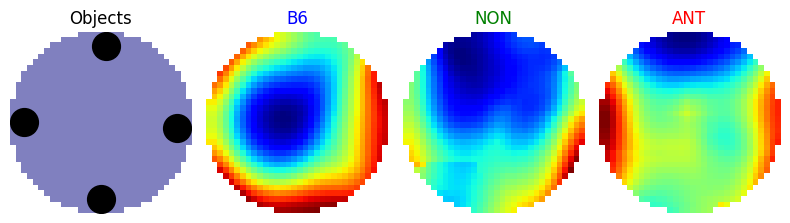

In [34]:
import copy

fig = plt.figure(figsize=(8,6))
clrs = ['k','b', 'g', 'r']
groups = ['All','B6', 'NON', 'ANT']
for i, group in enumerate(groups):
        if groups[i] != 'All':
                ax = plt.subplot(1,4, i+1)
                ax.imshow(avg_map_dict[group], cmap='jet')
                ax.set_title(group, color = clrs[i])
                ax.axis('off')
        else:
            ax = plt.subplot(1,4, i+1)
            map_to_plot = copy.deepcopy(avg_map_dict['B6'])
            blank_map = np.copy(map_to_plot)
            blank_map[blank_map == blank_map] = 0   
            ax.imshow(blank_map, cmap='jet', alpha=0.5)
            ax.set_title(str(angle), color=clrs[i])
            _, obj_loc = make_object_ratemap(0, new_size=32)
            ax.plot(obj_loc['x']+.5, obj_loc['y']+2, 'k', marker='o', markersize=20)
            _, obj_loc = make_object_ratemap(90, new_size=32)
            ax.plot(obj_loc['x']-2, obj_loc['y']+.5, 'k', marker='o', markersize=20)
            _, obj_loc = make_object_ratemap(180, new_size=32)
            ax.plot(obj_loc['x']-.5, obj_loc['y']-2, 'k', marker='o', markersize=20)
            _, obj_loc = make_object_ratemap(270, new_size=32)
            ax.plot(obj_loc['x']+2, obj_loc['y']-.5, 'k', marker='o', markersize=20)
            ax.axis('off')
            ax.set_title('Objects')
                
fig.tight_layout()
plt.show()

# savefig
# folder = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\Radha-Taub-Retreat"
# fig.savefig(os.path.join(folder, 'average_ratemaps.pdf'), dpi=1080, bbox_inches='tight')

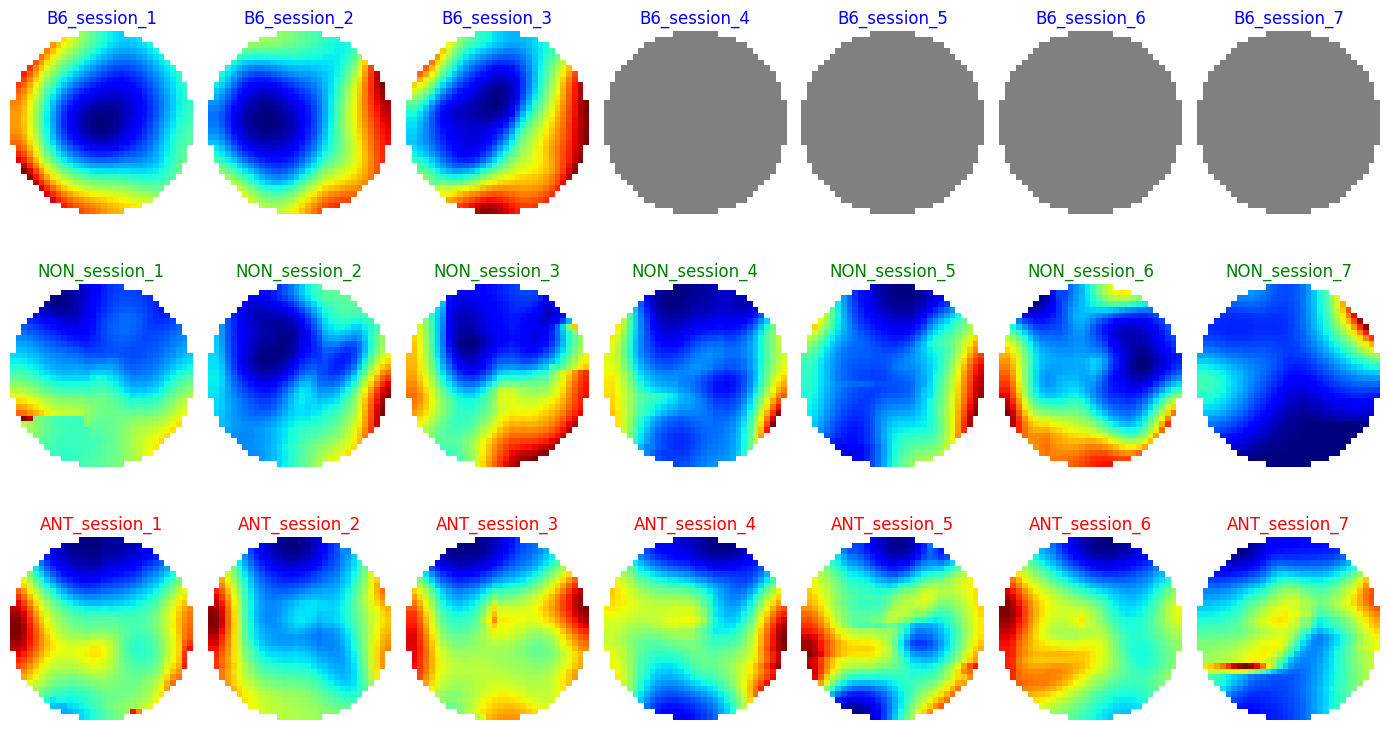

In [7]:
fig = plt.figure(figsize=(14,8))
bgr = ['blue', 'green', 'red']
for i, group in enumerate(groups):
    for j, ses in enumerate(session_groups):
        ax = plt.subplot(len(groups), len(session_groups), i*len(session_groups) + j + 1)

        if group == 'B6' and (ses == 'session_7' or ses == 'session_6' or ses == 'session_5' or ses == 'session_4'):
            shp = np.copy(avg_map_dict[group + '_' + 'session_1'])
            shp[shp == shp] = 0.5
            ax.imshow(shp, cmap='gray', vmin=0, vmax=1)
        else:  
            ax.imshow(avg_map_dict[group + '_' + str(ses)], cmap='jet')
        ax.set_title(group + '_' + str(ses), color=bgr[i])
        ax.axis('off')
fig.tight_layout()
plt.show()

# savefig
folder = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\Radha-Taub-Retreat"
fig.savefig(os.path.join(folder, 'average_ratemaps_ses.pdf'), dpi=1080, bbox_inches='tight')

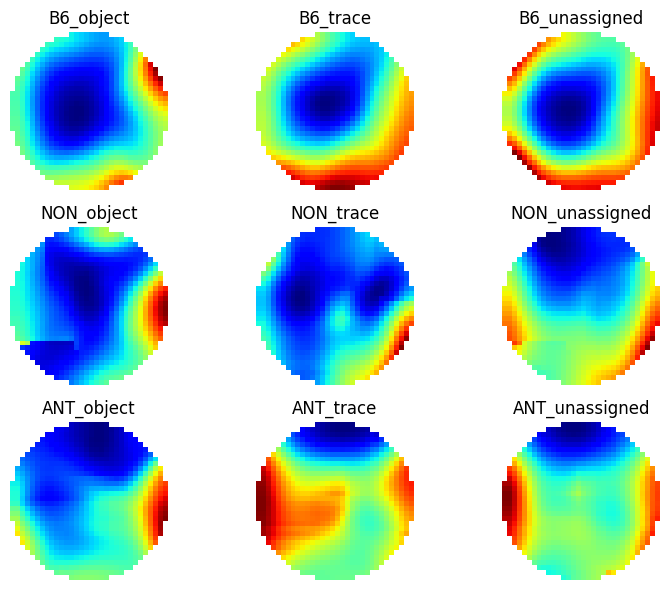

In [8]:
fig = plt.figure(figsize=(8,6))
for i, group in enumerate(groups):
    for j, ctype in enumerate(ctype_groups):
        ax = plt.subplot(len(groups), len(ctype_groups), i*len(ctype_groups) + j + 1)

        ax.imshow(avg_map_dict[group + '_' + str(ctype)], cmap='jet')
        ax.set_title(group + '_' + str(ctype))
        ax.axis('off')
fig.tight_layout()
plt.show()

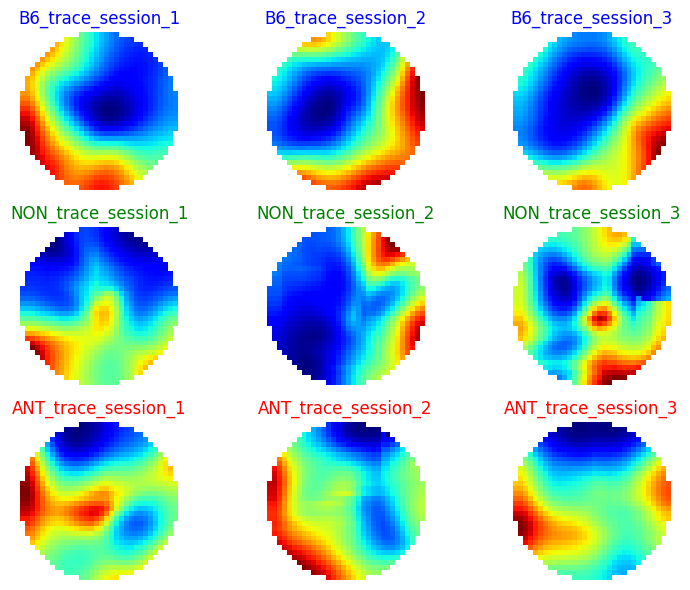

In [9]:
fig = plt.figure(figsize=(8,6))
ses_ids = ['session_1', 'session_2', 'session_3']
ctype = 'trace'
for i, group in enumerate(groups):
    for j, ses_id in enumerate(ses_ids):
        ax = plt.subplot(len(groups), len(ses_ids), i*len(ses_ids) + j + 1)

        ax.imshow(avg_map_dict[group + '_' + str(ctype) + '_' + str(ses_id)], cmap='jet')
        ax.set_title(group + '_' + str(ctype) + '_' + str(ses_id), color=bgr[i])
        ax.axis('off')
fig.tight_layout()
plt.show()

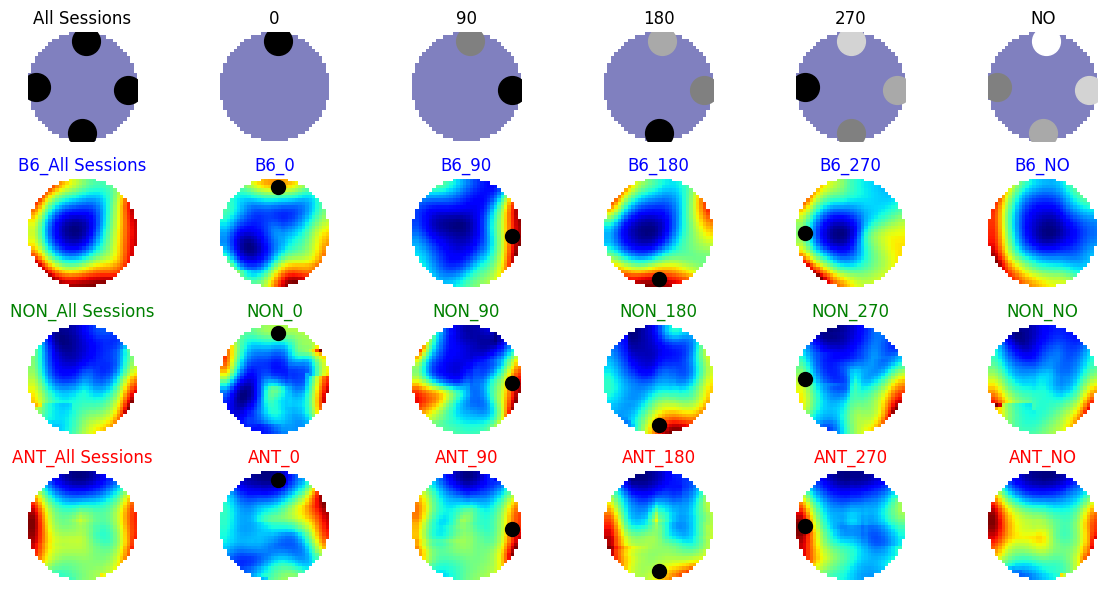

In [10]:
import matplotlib.pyplot as plt

angle_groups = ['All Sessions',0,90,180,270,'NO']
groups = ['Setup','B6', 'NON', 'ANT']
bgr = ['black','blue', 'green', 'red']

fig = plt.figure(figsize=(12,6))
for i, group in enumerate(groups):
    for j, angle in enumerate(angle_groups):
        # print(len(groups), len(angle_groups), int(i*len(angle_groups) + j + 1))

        ax = plt.subplot(len(groups), len(angle_groups), int(i*len(angle_groups) + j + 1))


        if group != 'Setup':
            ax.set_title(group + '_' + str(angle), color=bgr[i])

            if angle == 'All Sessions':
                ax.imshow(avg_map_dict[group], cmap='jet')

            else:
                ax.imshow(avg_map_dict[group + '_' + str(angle)], cmap='jet')
                if angle != 'NO':
                    angle = int(angle)
                    _, obj_loc = make_object_ratemap(angle, new_size=32)
                    
                    if angle == 0:
                        obj_loc['x'] += .5
                        obj_loc['y'] += 2
                    elif angle == 90:
                        obj_loc['y'] += .5
                        obj_loc['x'] -= 2
                    elif angle == 180:
                        obj_loc['x'] -= .5
                        obj_loc['y'] -= 2
                    elif angle == 270:
                        obj_loc['y'] -= .5
                        obj_loc['x'] += 2
                    ax.plot(obj_loc['x'], obj_loc['y'], 'k', marker='o', markersize=10)
                    
        else:
            import copy
            map_to_plot = copy.deepcopy(avg_map_dict['B6'])
            blank_map = np.copy(map_to_plot)
            blank_map[blank_map == blank_map] = 0   
            ax.imshow(blank_map, cmap='jet', alpha=0.5)
            ax.set_title(str(angle), color=bgr[i])
            if angle == 'All Sessions':
                _, obj_loc = make_object_ratemap(0, new_size=32)
                ax.plot(obj_loc['x']+.5, obj_loc['y']+2, 'k', marker='o', markersize=20)
                _, obj_loc = make_object_ratemap(90, new_size=32)
                ax.plot(obj_loc['x']-2, obj_loc['y']+.5, 'k', marker='o', markersize=20)
                _, obj_loc = make_object_ratemap(180, new_size=32)
                ax.plot(obj_loc['x']-.5, obj_loc['y']-2, 'k', marker='o', markersize=20)
                _, obj_loc = make_object_ratemap(270, new_size=32)
                ax.plot(obj_loc['x']+2, obj_loc['y']-.5, 'k', marker='o', markersize=20)
            else:
                if angle != 'NO':
                    angle = int(angle)
                    _, obj_loc = make_object_ratemap(angle, new_size=32)
                    
                    if angle == 0:
                        obj_loc['x'] += .5
                        obj_loc['y'] += 2
                        ax.plot(obj_loc['x'], obj_loc['y'], 'k', marker='o', markersize=20)
                    elif angle == 90:
                        obj_loc['y'] += .5
                        obj_loc['x'] -= 2
                        ax.plot(obj_loc['x'], obj_loc['y'], 'k', marker='o', markersize=20)
                        _, obj_loc = make_object_ratemap(angle-90, new_size=32)
                        ax.plot(obj_loc['x']+.5, obj_loc['y']+2, 'grey', marker='o', markersize=20)
                    elif angle == 180:
                        obj_loc['x'] -= .5
                        obj_loc['y'] -= 2
                        ax.plot(obj_loc['x'], obj_loc['y'], 'k', marker='o', markersize=20)
                        _, obj_loc = make_object_ratemap(angle-90, new_size=32)
                        ax.plot(obj_loc['x']-2, obj_loc['y']+.5, 'grey', marker='o', markersize=20)
                        _, obj_loc = make_object_ratemap(angle-180, new_size=32)
                        ax.plot(obj_loc['x']+.5, obj_loc['y']+2, 'darkgray', marker='o', markersize=20)
                    elif angle == 270:
                        obj_loc['y'] -= .5
                        obj_loc['x'] += 2
                        ax.plot(obj_loc['x'], obj_loc['y'], 'k', marker='o', markersize=20)
                        _, obj_loc = make_object_ratemap(angle-90, new_size=32)
                        ax.plot(obj_loc['x']-.5, obj_loc['y']-2, 'grey', marker='o', markersize=20)
                        _, obj_loc = make_object_ratemap(angle-180, new_size=32)
                        ax.plot(obj_loc['x']-2, obj_loc['y']+.5, 'darkgray', marker='o', markersize=20)
                        _, obj_loc = make_object_ratemap(angle-270, new_size=32)
                        ax.plot(obj_loc['x']-.5, obj_loc['y']+2, 'lightgrey', marker='o', markersize=20)
                else:
                    _, obj_loc = make_object_ratemap(270, new_size=32)
                    ax.plot(obj_loc['x']+2, obj_loc['y']-.5, 'grey', marker='o', markersize=20)
                    _, obj_loc = make_object_ratemap(180, new_size=32)
                    ax.plot(obj_loc['x']-.5, obj_loc['y']-2, 'darkgray', marker='o', markersize=20)
                    _, obj_loc = make_object_ratemap(90, new_size=32)
                    ax.plot(obj_loc['x']-2, obj_loc['y']+.5, 'lightgrey', marker='o', markersize=20)
                    _, obj_loc = make_object_ratemap(0, new_size=32)
                    ax.plot(obj_loc['x']+.5, obj_loc['y']+2, 'white', marker='o', markersize=20)

        ax.axis('off')

fig.tight_layout()
plt.show()

# savefig
# folder = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\Radha-Taub-Retreat"
# fig.savefig(os.path.join(folder, 'average_ratemaps_angles.pdf'), dpi=1080, bbox_inches='tight')

In [11]:
stop()

NameError: name 'stop' is not defined

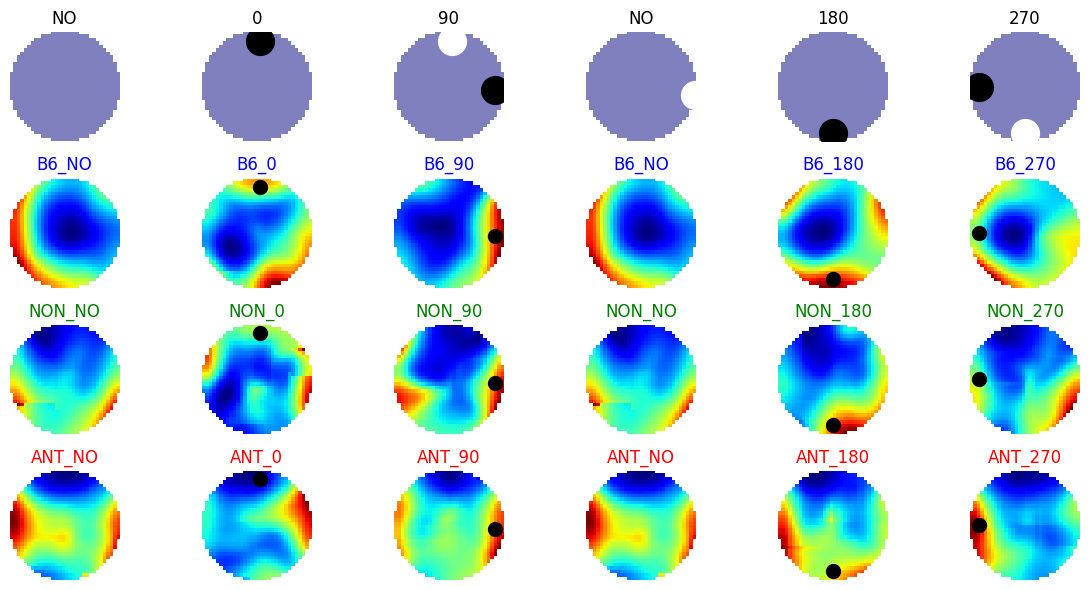

In [22]:
import matplotlib.pyplot as plt

visitedNO = False
# angle_groups = ['All Sessions',0,90,180,270,'NO']
angle_groups = ['NO', 0, 90, 'NO', 180, 270]
groups = ['Setup','B6', 'NON', 'ANT']
bgr = ['black','blue', 'green', 'red']

fig = plt.figure(figsize=(12,6))
for i, group in enumerate(groups):
    for j, angle in enumerate(angle_groups):
        # print(len(groups), len(angle_groups), int(i*len(angle_groups) + j + 1))

        ax = plt.subplot(len(groups), len(angle_groups), int(i*len(angle_groups) + j + 1))


        if group != 'Setup':
            ax.set_title(group + '_' + str(angle), color=bgr[i])

            if angle == 'All Sessions':
                ax.imshow(avg_map_dict[group], cmap='jet')

            else:
                ax.imshow(avg_map_dict[group + '_' + str(angle)], cmap='jet')
                if angle != 'NO':
                    angle = int(angle)
                    _, obj_loc = make_object_ratemap(angle, new_size=32)
                    
                    if angle == 0:
                        obj_loc['x'] += .5
                        obj_loc['y'] += 2
                    elif angle == 90:
                        obj_loc['y'] += .5
                        obj_loc['x'] -= 2
                    elif angle == 180:
                        obj_loc['x'] -= .5
                        obj_loc['y'] -= 2
                    elif angle == 270:
                        obj_loc['y'] -= .5
                        obj_loc['x'] += 2
                    ax.plot(obj_loc['x'], obj_loc['y'], 'k', marker='o', markersize=10)
                    
        else:
            import copy
            map_to_plot = copy.deepcopy(avg_map_dict['B6'])
            blank_map = np.copy(map_to_plot)
            blank_map[blank_map == blank_map] = 0   
            ax.imshow(blank_map, cmap='jet', alpha=0.5)
            ax.set_title(str(angle), color=bgr[i])
            if angle == 'All Sessions':
                _, obj_loc = make_object_ratemap(0, new_size=32)
                ax.plot(obj_loc['x']+.5, obj_loc['y']+2, 'k', marker='o', markersize=20)
                _, obj_loc = make_object_ratemap(90, new_size=32)
                ax.plot(obj_loc['x']-2, obj_loc['y']+.5, 'k', marker='o', markersize=20)
                _, obj_loc = make_object_ratemap(180, new_size=32)
                ax.plot(obj_loc['x']-.5, obj_loc['y']-2, 'k', marker='o', markersize=20)
                _, obj_loc = make_object_ratemap(270, new_size=32)
                ax.plot(obj_loc['x']+2, obj_loc['y']-.5, 'k', marker='o', markersize=20)
            else:
                if angle != 'NO':
                    angle = int(angle)
                    _, obj_loc = make_object_ratemap(angle, new_size=32)
                    
                    if angle == 0:
                        obj_loc['x'] += .5
                        obj_loc['y'] += 2
                        ax.plot(obj_loc['x'], obj_loc['y'], 'k', marker='o', markersize=20)
                    elif angle == 90:
                        obj_loc['y'] += .5
                        obj_loc['x'] -= 2
                        ax.plot(obj_loc['x'], obj_loc['y'], 'k', marker='o', markersize=20)
                        _, obj_loc = make_object_ratemap(angle-90, new_size=32)
                        ax.plot(obj_loc['x']+.5, obj_loc['y']+2, 'white', marker='o', markersize=20)
                    elif angle == 180:
                        obj_loc['x'] -= .5
                        obj_loc['y'] -= 2
                        ax.plot(obj_loc['x'], obj_loc['y'], 'k', marker='o', markersize=20)
                        _, obj_loc = make_object_ratemap(angle-90, new_size=32)
                        # ax.plot(obj_loc['x']-2, obj_loc['y']+.5, 'grey', marker='o', markersize=20)
                        # _, obj_loc = make_object_ratemap(angle-180, new_size=32)
                        # ax.plot(obj_loc['x']+.5, obj_loc['y']+2, 'darkgray', marker='o', markersize=20)
                    elif angle == 270:
                        obj_loc['y'] -= .5
                        obj_loc['x'] += 2
                        ax.plot(obj_loc['x'], obj_loc['y'], 'k', marker='o', markersize=20)
                        _, obj_loc = make_object_ratemap(angle-90, new_size=32)
                        ax.plot(obj_loc['x']-.5, obj_loc['y']-2, 'white', marker='o', markersize=20)
                        _, obj_loc = make_object_ratemap(angle-180, new_size=32)
                        # ax.plot(obj_loc['x']-2, obj_loc['y']+.5, 'white', marker='o', markersize=20)
                        _, obj_loc = make_object_ratemap(angle-270, new_size=32)
                        # ax.plot(obj_loc['x']-.5, obj_loc['y']+2, 'lightgrey', marker='o', markersize=20)
                else:
                    if visitedNO:
                        _, obj_loc = make_object_ratemap(180-90, new_size=32)
                        ax.plot(obj_loc['x']+.5, obj_loc['y']+2, 'white', marker='o', markersize=20)
                    else:
                        visitedNO = True
                    # _, obj_loc = make_object_ratemap(270, new_size=32)
                    # ax.plot(obj_loc['x']+2, obj_loc['y']-.5, 'grey', marker='o', markersize=20)
                    # _, obj_loc = make_object_ratemap(180, new_size=32)
                    # ax.plot(obj_loc['x']-.5, obj_loc['y']-2, 'darkgray', marker='o', markersize=20)
                    # _, obj_loc = make_object_ratemap(90, new_size=32)
                    # ax.plot(obj_loc['x']-2, obj_loc['y']+.5, 'lightgrey', marker='o', markersize=20)
                    # _, obj_loc = make_object_ratemap(0, new_size=32)
                    # ax.plot(obj_loc['x']+.5, obj_loc['y']+2, 'white', marker='o', markersize=20)

        ax.axis('off')

fig.tight_layout()
plt.show()

# savefig
# folder = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\Radha-Taub-Retreat"
# fig.savefig(os.path.join(folder, 'average_ratemaps_angles.pdf'), dpi=1080, bbox_inches='tight')

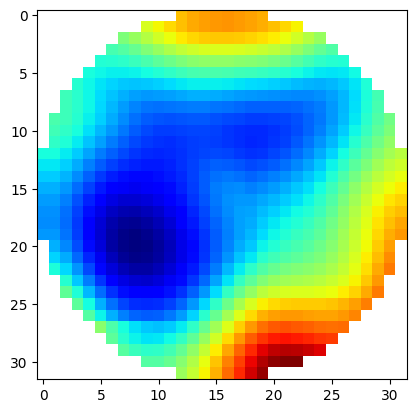

In [ ]:
plt.imshow(avg_map_dict['B6_0'], cmap='jet')

In [ ]:
avg_map_dict.keys()

dict_keys(['B6', 'B6_0', 'B6_90', 'B6_180', 'B6_270', 'B6_NO', 'B6_session_1', 'B6_session_2', 'B6_session_3', 'B6_session_4', 'B6_session_5', 'B6_session_6', 'B6_object', 'B6_object_session_1', 'B6_object_session_2', 'B6_object_session_3', 'B6_trace', 'B6_trace_session_1', 'B6_trace_session_2', 'B6_trace_session_3', 'B6_unassigned', 'B6_unassigned_session_1', 'B6_unassigned_session_2', 'B6_unassigned_session_3', 'NON', 'NON_0', 'NON_90', 'NON_180', 'NON_270', 'NON_NO', 'NON_session_1', 'NON_session_2', 'NON_session_3', 'NON_session_4', 'NON_session_5', 'NON_session_6', 'NON_session_7', 'NON_object', 'NON_object_session_1', 'NON_object_session_2', 'NON_object_session_3', 'NON_trace', 'NON_trace_session_1', 'NON_trace_session_2', 'NON_trace_session_3', 'NON_unassigned', 'NON_unassigned_session_1', 'NON_unassigned_session_2', 'NON_unassigned_session_3', 'ANT', 'ANT_0', 'ANT_90', 'ANT_180', 'ANT_270', 'ANT_NO', 'ANT_session_1', 'ANT_session_2', 'ANT_session_3', 'ANT_session_4', 'ANT_sessi

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 34.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 17.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 36.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 18.9% of the points cannot be p

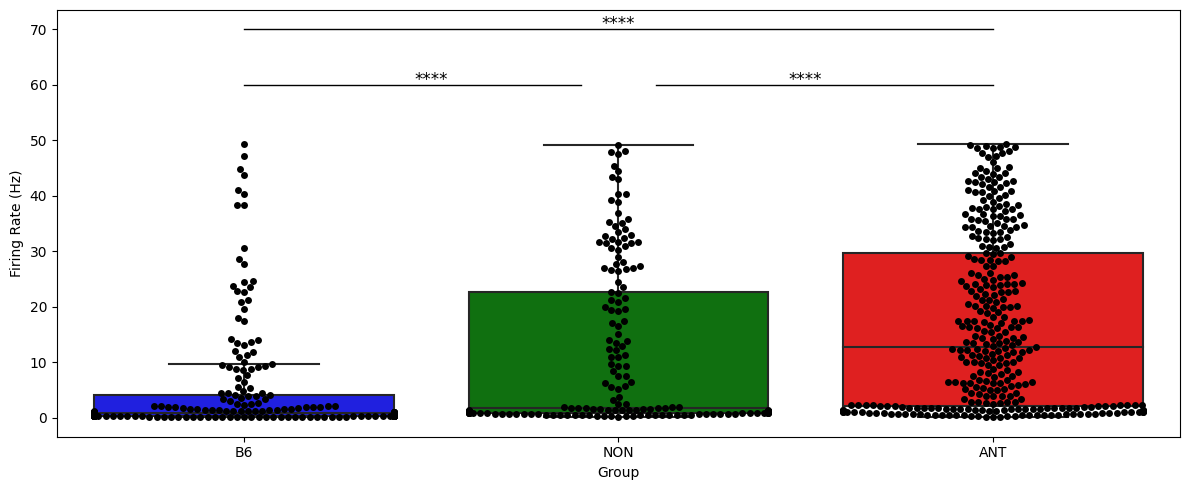

In [ ]:
csv_path = r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\_prototypes\cell_remapping\LEC_paper\Firing_Rate_ANT_NON_B6.xlsx'

df = pd.read_excel(csv_path, sheet_name='Sheet1')

ANT = df['ANT']
NON = df['NON']
B6 = df['B6']

clrs = ['blue', 'green', 'red']
vals = [B6, NON, ANT]

# convert str to float
for i in range(len(vals)):
    vals[i] = vals[i].values
    arr = []
    for val in vals[i]:
        if type(val) != float:
            val = str(val).replace('*', '')
        arr.append(val)
    vals_use = np.array(arr ,dtype=np.float32)
    vals_use = vals_use[~np.isnan(vals_use)]
    vals[i] = vals_use

fig = plt.figure(figsize=(12,5))
# boxplot
ax = plt.subplot(1,1,1)

# # plot B6 only 
# ln1 = ax.boxplot(vals[0], positions=[1], widths=0.5, patch_artist=True, boxprops=dict(facecolor=clrs[0]), medianprops=dict(color='black'), showfliers=False)
# ln2 = ax.boxplot(vals[1], positions=[2], widths=0.5, patch_artist=True, boxprops=dict(facecolor=clrs[1]), medianprops=dict(color='black'), showfliers=False)
# ln3 = ax.boxplot(vals[2], positions=[3], widths=0.5, patch_artist=True, boxprops=dict(facecolor=clrs[2]), medianprops=dict(color='black'), showfliers=False)

# # swarmplot
# tempdf = pd.DataFrame()
# # tempdf['group'] = 'B6'
# tempdf['B6'] = vals[0]
# smplt = sns.swarmplot(y='B6', x=np.ones(len(vals[0])), data=tempdf, color='black', size=5, ax=ax)

# sns boxplot with swarmplot
tempdf = pd.DataFrame()
b6labs = ['B6']*len(vals[0])
nonlabs = ['NON']*len(vals[1])
antlabs = ['ANT']*len(vals[2])
tempdf['group'] = np.concatenate((b6labs, nonlabs, antlabs))
tempdf['FR'] = np.concatenate((vals[0], vals[1], vals[2]))

sns.boxplot(x='group', y='FR', data=tempdf, ax=ax, palette=clrs, showfliers=False)
sns.swarmplot(x='group', y='FR', data=tempdf, ax=ax, color='black', size=5)

# add significance
ax.plot([0,2], [70,70], 'k', linewidth=1)
ax.text(1, 70, '****', fontsize=12, horizontalalignment='center')
ax.plot([0,.9], [60,60], 'k', linewidth=1)
ax.text(.5, 60, '****', fontsize=12, horizontalalignment='center')
ax.plot([1.1,2], [60,60], 'k', linewidth=1)
ax.text(1.5, 60, '****', fontsize=12, horizontalalignment='center')


ax.set_ylabel('Firing Rate (Hz)')
ax.set_xlabel('Group')
fig.tight_layout()
plt.show()


In [ ]:
df.columns

Index(['ANT', 'NON', 'B6'], dtype='object')